In [219]:
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install scikit-learn
#!pip install seaborn
#!pip install timeeval
#pip install matplotlib, statsmodels, scikit-learn, seaborn, timeeval

In [220]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
#from utils import rolling_forecast

In [221]:
channel_name = 'channel_44'
df = pd.read_csv('../datasets/channel_44_subset.csv', parse_dates=['timestamp'], index_col='timestamp')
df.head(2)
df.index.freq = pd.infer_freq(df.index)


In [222]:
df_time_diffs = df.index.to_series().diff().dt.total_seconds()  
print(df_time_diffs.value_counts())


timestamp
30.0    48363
Name: count, dtype: int64


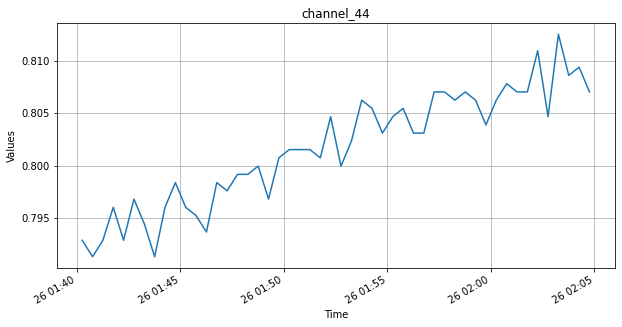

In [223]:
dt_from = '2000-01-26 01:40:00'
dt_to   = '2000-01-26 02:05:00'
ldf = df[(df.index >= dt_from) & (df.index <= dt_to)]

plt.figure(figsize=(10, 5))
plt.plot(ldf.index, ldf[channel_name], label=channel_name)
plt.title(channel_name)
plt.xlabel("Time")      
plt.ylabel("Values")
#plt.set_major_locator(mdates.DayLocator(interval=7))  # cada 7 días
plt.gcf().autofmt_xdate()  # Ajusta las fechas automáticamente
plt.grid()
plt.show()


## Primera pregunta. ¿Es estacionaria la serie?
### Aplicamos ADF

In [224]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ldf[channel_name])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8035614886872368
p-value: 0.8180736680173236


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [225]:
ldf.loc[:,['values_diff']] = ldf[channel_name].diff()
df_diff1 = ldf.copy()
df_diff1 = df_diff1.dropna(subset=['values_diff'])

Dibujamos valores y diferencia orden 1

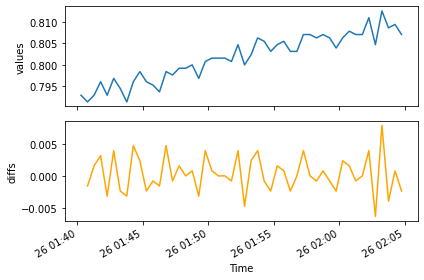

In [226]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(ldf[channel_name])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

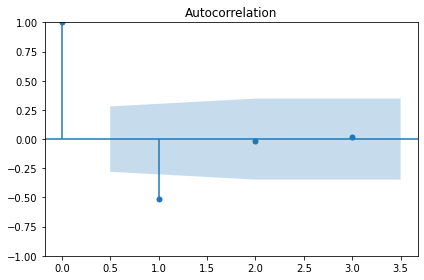

In [227]:
plot_acf(df_diff1["values_diff"], lags=3)
plt.tight_layout()
plt.show()
#MA(22)?

¿Es un random walk? => No, es un moving average de 1

Forecasting a moving average process

In [228]:
train_percent = 0.8
train = df_diff1[["values_diff"]][:int(train_percent*len(df_diff1))]
test = df_diff1[["values_diff"]][int((train_percent)*len(df_diff1)):]
print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")

Train set length: 39
Test set length: 10


In [229]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, order: int) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            
            model = SARIMAX(df[:i], order=(0,0,order))
            #res es diferente a sklearn, res es el resultado y las herramientas para realizar predicciones
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR


In [230]:
TRAIN_LEN   = len(train)
HORIZON     = len(test)
WINDOW      = 1
ORDER       = 1  # AR(3)

pred_mean       = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'mean', order=ORDER)
pred_last_value = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'last', order=ORDER)
pred_MA         = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'MA', order=ORDER)

test['pred_mean']       = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_MA']         = pred_MA

c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


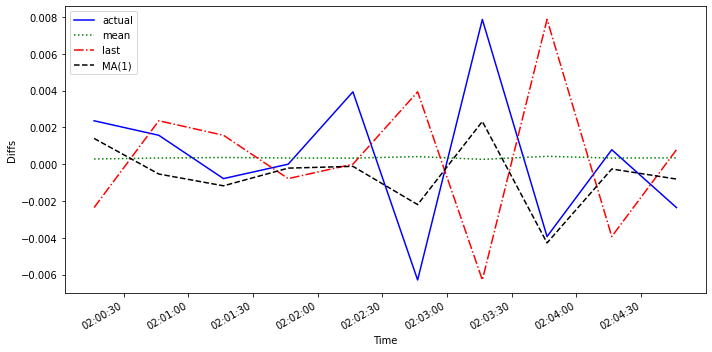

In [231]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(df['values'])
ax.plot(test['values_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_MA'], 'k--', label='MA(1)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diffs')
#ax.axvspan(947, 998, color='#808080', alpha=0.2)
#ax.set_xlim(920, 999)
#plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

¿Que modelo dio mejor? (MSE)

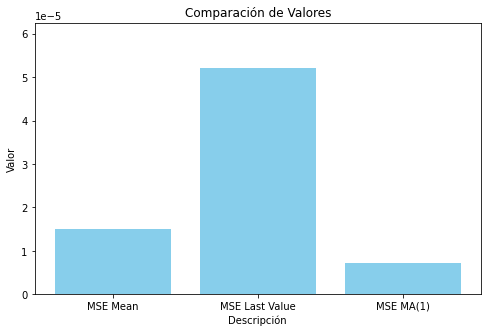

In [232]:
from sklearn.metrics import mean_squared_error
mse_mean    = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last    = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_MA      = mean_squared_error(test['values_diff'], test['pred_MA'])

df_comm = pd.DataFrame({
    'Descripción': ['MSE Mean', 'MSE Last Value', 'MSE MA(1)'],
    'Valor': [mse_mean, mse_last, mse_MA]
})

plt.figure(figsize=(8, 5))
plt.bar(df_comm['Descripción'], df_comm['Valor'], color='skyblue')

plt.title('Comparación de Valores')
plt.xlabel('Descripción')
plt.ylabel('Valor')
plt.ylim(0, max(df_comm['Valor']) * 1.2)  # margen superior
plt.show()

Ganó MA. La ventaja es clara.

Volvemos a los datos originales (Aca hay un problema, claramente)

In [236]:
df_diff1.loc[test.index, ["Predicted_diffs"]] = test["pred_MA"]

In [237]:
#len(ldf["pred_MA"][len(train):])
#len(df_diff1.loc[:, channel_name][len(train)]+test['pred_MA'].cumsum())
df_diff1["Predicted_serie"] = df_diff1.loc[:, channel_name][len(train)]+test['pred_MA'].cumsum()


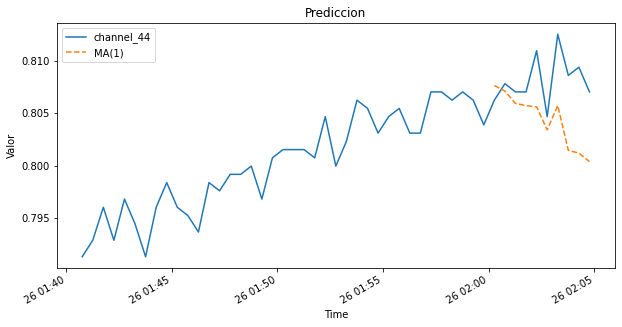

In [238]:
plt.figure(figsize=(10, 5))
plt.plot(df_diff1.index, df_diff1[channel_name], label=channel_name)
plt.plot(df_diff1.index, df_diff1["Predicted_serie"], label='MA(1)', linestyle='--')
plt.title("Prediccion")
plt.xlabel("Time")      
plt.ylabel("Valor")
plt.gcf().autofmt_xdate()   
plt.legend()
plt.show()